In [1]:
# import core python packages that we'll use for plotting and data manipulation.
import sys
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import platform

import petthermotools as ptt 

ptt.__version__

'0.3.8'

In [3]:
## If using Mac run this cell **twice** 
if platform.system() == "Darwin":
    sys.stdout = open(os.devnull, 'w')
    sys.stderr = open(os.devnull, 'w')

# Magma Crystallization, assessing the influence of P, fO2, H2O, and CO2 on phase stability

Welcome to part 2 of the PetThermoTools workshop!

The plan here is to start by running some simple fractional crystallization calculations, change key variables (e.g., H2O, P, fO2 etc.), and see how these variables influence mineral stability and the composition of the resulting melt phase. However, rather than just running random calculations, let's create a real scientific question: **can variations in the crysatllization parameters control whether a magma follows a calc-alkaline or tholeiite differentiation trend?**

Calc-alkaline magmas (relative) to tholeiites are broadly characterized by an early depletion in FeO, and enrichment in SiO2. I'm sure many people in this workshop know more about this than I do! What we want to do in this notebook, is investigate how variations in the variables controlling crystallization might influence tholeiite vs calc-alkaline differentiation trends. Tholeiitic trends are characterised by an increase in the FeO content of a magma prior to any significant increase in the melt SiO$_2$, Na$_2$O, or K$_2$O contents. This Fe-enrichment is not seen in calc-alkaline suites. Therefore, we're looking for some variable (e.g., pressure, H$_2$O content, oxygen fugacity) that controls the proportion of Fe-poor, Si-rich minerals (tholeiite) and an Fe-rich, Si-poor minerals (calc-alkaline) crystallising from an arc magma. 

The Aleutians is an interesting place to study the origin of calc-alkaline and tholeiitic differentiation trends as both suites are found along the arc: calc-alkaline trends typically dominate in the NE, where volcanism displays more similarities to continental arc volcanism. By contrast, as you move towards the SW the compositional trends become increasingly tholeiitic.

![alt text](https://plate-tectonic.narod.ru/aleutians010101.gif)

To answer this question, we need to do some modelling, which is what you're all here for!

We can use thermodynamic models (e.g., rhyolite-MELTS v1.0.2) to predict what phases will crystallise from a magma at a given pressure and temperature, and follow a differentiation sequence from high to low temperature. No thermodynamic model is perfect (we'll hear more on this tomorrow), but most do a good job at predicting the influence of internal parameters (such as pressure or melt H$_2$O content) on phase stability.

## Part 1 - Simple crystallization models - and comparison to data
**Let's start by loading in some chemical data from erupted products in the Aleutians (downloaded form GEOROC), specifically from the volcanoes Augustine and Shishaldin.**

In [4]:
Aleu = pd.read_excel("Aleutians.xlsx")
Aleu['Volcano'].unique()

array(['Augustine', 'Shishaldin', 'Okmok'], dtype=object)

**We can use the `isobaric_crystallisation` function to simulation crystallization at a set pressure. The code below will run 1 fractional crystallization calcualtion (as only 1 composition, pressure, water content, and oxygen fugacity is specified, and both `Frac_solid` and `Frac_fluid` are set to True). The composition used is from a wider Aleutian dataset and represents a high-MgO composition that lies near the tholeiite - calc-alkaline divide.**

In [5]:
### Starting composition represents a high-MgO sample from the Aleutians that lies near the tholeiite - calc-alkaline divide. ####
Aleutian = {'SiO2_Liq': 50.04,
       'TiO2_Liq': 0.81,
       'Al2O3_Liq': 15.01,
       'FeOt_Liq': 9.62,
       'MnO_Liq': 0.16,
       'MgO_Liq': 7.28,
       'CaO_Liq': 11.52,
       'Na2O_Liq': 2.54,
       'K2O_Liq': 0.30,
       'P2O5_Liq': 0.06}

Isobaric_Xtal = ptt.isobaric_crystallisation(Model = "MELTSv1.2.0",
                                           bulk = Aleutian,
                                           find_liquidus = True,
                                           P_bar = 2000,
                                           H2O_init=2,
                                           T_end_C = 900,
                                           dt_C = 2,
                                           fO2_buffer = "FMQ",
                                           fO2_offset = 0,
                                           Frac_solid = True,
                                           Frac_fluid = True,
                                           timeout=90)

**Let's look at the output - what different properties are returned by the calculation?**

In [6]:
Isobaric_Xtal.keys()

dict_keys(['Conditions', 'liquid1', 'liquid1_prop', 'clinopyroxene1', 'clinopyroxene1_prop', 'plagioclase1', 'plagioclase1_prop', 'olivine1', 'olivine1_prop', 'spinel1', 'spinel1_prop', 'clinopyroxene2', 'clinopyroxene2_prop', 'fluid1', 'fluid1_prop', 'All', 'PhaseList', 'mass_g', 'volume_cm3', 'rho_kg/m3'])

In [7]:
Isobaric_Xtal['liquid1'].head()

,SiO2_Liq,TiO2_Liq,Al2O3_Liq,Cr2O3_Liq,Fe2O3_Liq,FeO_Liq,FeOt_Liq,MnO_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,P2O5_Liq,H2O_Liq,CO2_Liq,Fe3Fet_Liq
0,50.291361,0.817577,15.188116,0.0,1.688432,8.180696,9.699936,0.162473,7.230100,11.480994,2.577459,0.304636,0.060927,2.017229,0.0,0.156624
1,50.289449,0.820579,15.279819,0.0,1.690642,8.206319,9.727548,0.163977,7.151897,11.392774,2.599692,0.307456,0.061491,2.035903,0.0,0.156384
2,50.288190,0.823445,15.370971,0.0,1.692782,8.231456,9.754611,0.165482,7.074173,11.304658,2.621919,0.310278,0.062056,2.054589,0.0,0.156147
3,50.287584,0.826174,15.461571,0.0,1.694852,8.256106,9.781123,0.166988,6.996929,11.216649,2.644139,0.313102,0.062620,2.073286,0.0,0.155914
4,50.287633,0.828763,15.551617,0.0,1.696853,8.280266,9.807084,0.168494,6.920165,11.128750,2.666352,0.315927,0.063185,2.091994,0.0,0.155685


**PetThermoTools includes som built-in plotting options. One of these creates classic `harker` plots. By default MgO is on the x-axis.**

(<Figure size 960x900 with 9 Axes>,
 array([[<Axes: xlabel='MgO', ylabel='SiO$_2$'>,
         <Axes: xlabel='MgO', ylabel='TiO$_2$'>,
         <Axes: xlabel='MgO', ylabel='Al$_2$O$_3$'>],
        [<Axes: xlabel='MgO', ylabel='FeO$_t$'>,
         <Axes: xlabel='MgO', ylabel='CaO'>,
         <Axes: xlabel='MgO', ylabel='Na$_2$O'>],
        [<Axes: xlabel='MgO', ylabel='K$_2$O'>, <Axes: >, <Axes: >]],
       dtype=object))

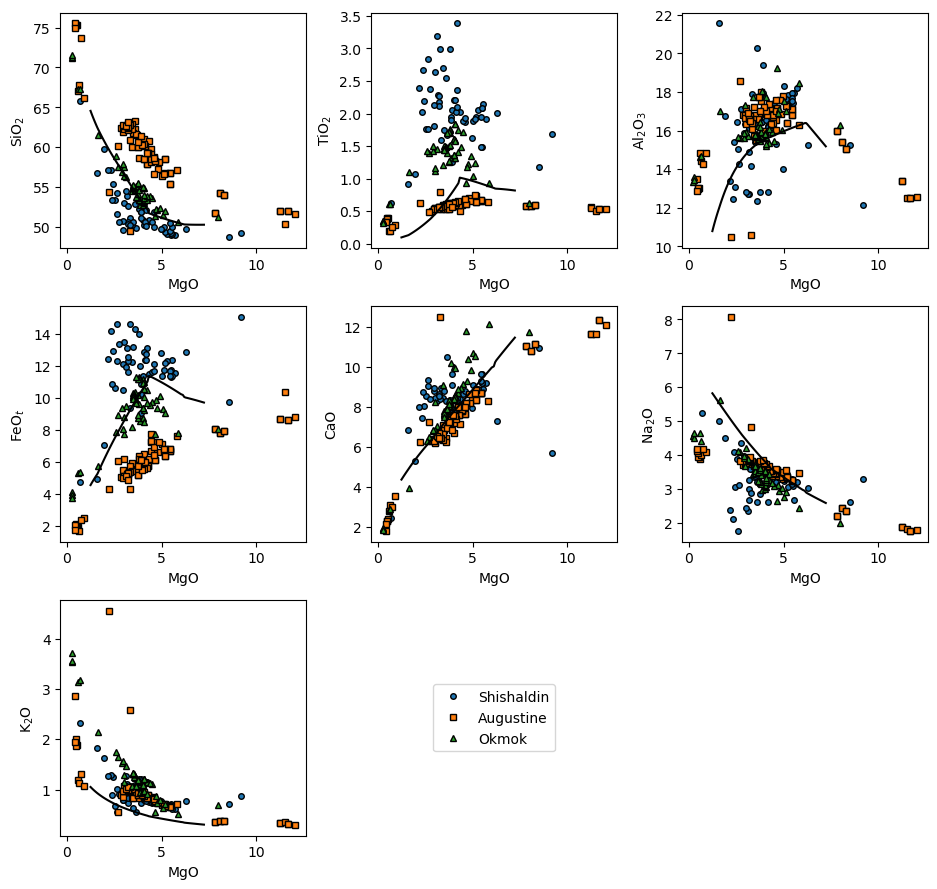

In [8]:
ptt.harker(Results=Isobaric_Xtal, data = {'Shishaldin': Aleu.loc[Aleu['Volcano'] == "Shishaldin"],
                                          'Augustine': Aleu.loc[Aleu['Volcano'] == 'Augustine'],
                                          'Okmok': Aleu.loc[Aleu['Volcano'] == "Okmok"]})

**We can also examine the mass of each phase. Note, because we've used an fO2 buffer the mass of the system is not constant (open system) which is why the 'mass fraction' (which is referenced to the initial mass of the system) goes above 100.**

(<Figure size 500x350 with 1 Axes>,
 <Axes: xlabel='T_C', ylabel='Mass fraction'>)

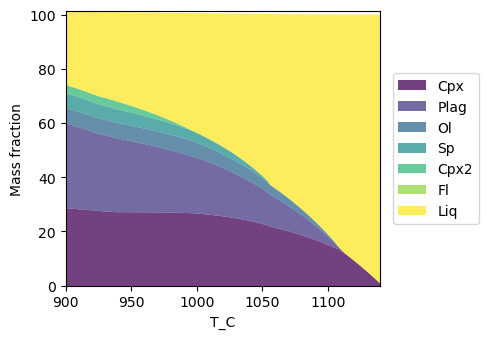

In [9]:
ptt.phase_plot(Results=Isobaric_Xtal, x_axis = "T_C", cmap = 'viridis')

(<Figure size 500x350 with 1 Axes>,
 <Axes: xlabel='T_C', ylabel='Mass fraction'>)

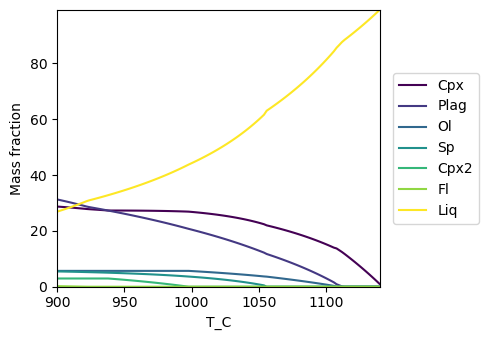

In [10]:
ptt.phase_plot(Results=Isobaric_Xtal, x_axis = "T_C", cmap = 'viridis', lines = True)

## Part 2 - Running multiple calculations, exploring the influence of different parameters

Okay, so that model shows us one possible crystallization scenarion. But by itself it doesn't tell us much about tholeiite vs calc-alkaline trends. Let's try adjusting some of the input parameters starting with the initial H2O content.

In the cell below we specify 4 different H2O contents for the system. Run the calculation and the following cell to see how this influence the output structure!

In [11]:
Isobaric_Xtal_H2O = ptt.isobaric_crystallisation(Model = "MELTSv1.2.0",
                                           bulk = Aleutian,
                                           find_liquidus = True,
                                           P_bar = 2000,
                                           H2O_init=[0.5, 2, 4, 6],
                                           T_end_C = 900,
                                           dt_C = 2,
                                           fO2_buffer = "FMQ",
                                           fO2_offset = 0,
                                           Frac_solid = True,
                                           Frac_fluid = True,
                                           label = "H2O_init",
                                           timeout=90)

In [12]:
Isobaric_Xtal_H2O.keys()

dict_keys(['H2O = 0.5 wt%', 'H2O = 2.0 wt%', 'H2O = 4.0 wt%', 'H2O = 6.0 wt%'])

In [13]:
Isobaric_Xtal_H2O['H2O = 2.0 wt%'].keys()

dict_keys(['Conditions', 'liquid1', 'liquid1_prop', 'clinopyroxene1', 'clinopyroxene1_prop', 'plagioclase1', 'plagioclase1_prop', 'olivine1', 'olivine1_prop', 'spinel1', 'spinel1_prop', 'clinopyroxene2', 'clinopyroxene2_prop', 'fluid1', 'fluid1_prop', 'All', 'PhaseList', 'mass_g', 'volume_cm3', 'rho_kg/m3', 'Input'])

**You should see that there is now a 'higher level' dictionary that contains the results from each individual calculation. With PetThermoTools we can now provide that entire dictionary (results variable) to the `harker` function to view the different crystallization models side-by-side.**

(<Figure size 960x900 with 9 Axes>,
 array([[<Axes: xlabel='MgO', ylabel='SiO$_2$'>,
         <Axes: xlabel='MgO', ylabel='TiO$_2$'>,
         <Axes: xlabel='MgO', ylabel='Al$_2$O$_3$'>],
        [<Axes: xlabel='MgO', ylabel='FeO$_t$'>,
         <Axes: xlabel='MgO', ylabel='CaO'>,
         <Axes: xlabel='MgO', ylabel='Na$_2$O'>],
        [<Axes: xlabel='MgO', ylabel='K$_2$O'>, <Axes: >, <Axes: >]],
       dtype=object))

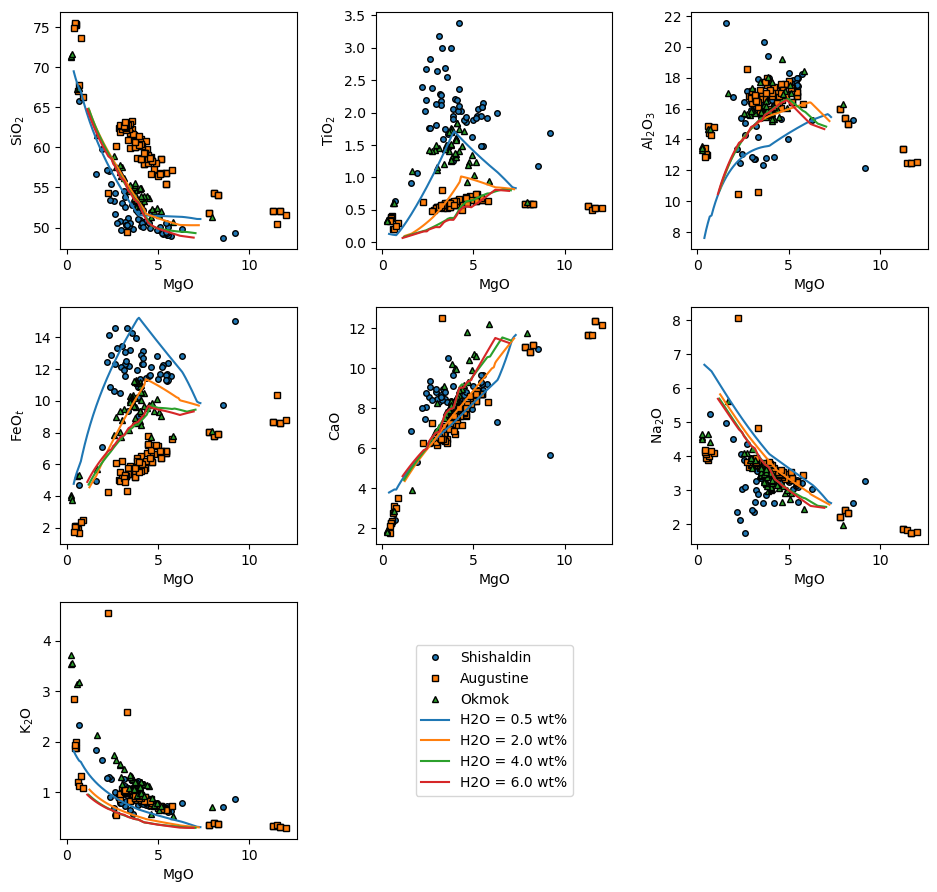

In [14]:
ptt.harker(Results=Isobaric_Xtal_H2O, data = {'Shishaldin': Aleu.loc[Aleu['Volcano'] == "Shishaldin"],
                                          'Augustine': Aleu.loc[Aleu['Volcano'] == 'Augustine'],
                                          'Okmok': Aleu.loc[Aleu['Volcano'] == "Okmok"]})

**We can also plot the results on a diagram from Miyashiro 1974 that separates the calc-alkaline and tholeiitic trends in FeO/MgO vs SiO2 space.**

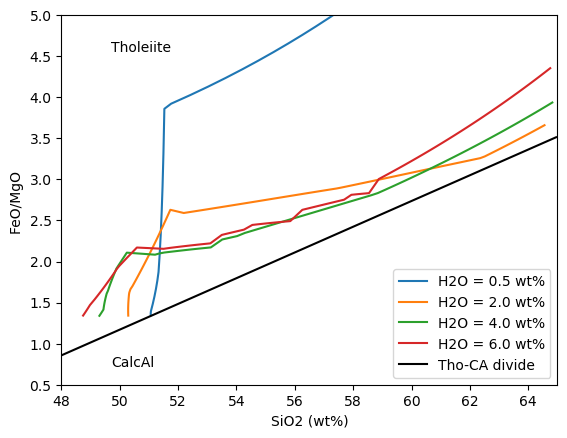

In [15]:
# Lets loop through the different keys and plot FeO vs MgO
x='SiO2_Liq'
y='FeO/MgO'
for key in Isobaric_Xtal_H2O.keys():
    # Lets add a column for FeO/MgO
    Isobaric_Xtal_H2O[key]['All']['FeO/MgO']=Isobaric_Xtal_H2O[key]['All']['FeOt_Liq']/Isobaric_Xtal_H2O[key]['All']['MgO_Liq']
    plt.plot(Isobaric_Xtal_H2O[key]['All'][x],Isobaric_Xtal_H2O[key]['All'][y],
         '-', label=key)
    
# Lets add approximate boundary from web plot digitizer!
plt.plot([45, 64.95495495495496],  [0.3876918668171161, 3.5129224652087476], '-k', label='Tho-CA divide')
plt.xlim([48, 65])
plt.ylim([0.5, 5])
plt.annotate('CalcAl', xy=[0.1, 0.05], xycoords="axes fraction", fontsize=10)
plt.annotate('Tholeiite', xy=[0.1, 0.9], xycoords="axes fraction", fontsize=10)
plt.ylabel('FeO/MgO ')
plt.xlabel('SiO2 (wt%)')
plt.legend()

### Now it's time for you to do some coding.

**Recreate the calculations above, but instead of varying the system H2O, change the offset from the FMQ fO2 buffer. Plot up the results on the Miyashiro 1974 diagram. Does H2O or fO2 appear to have a larger influence on the composition of the melt phase (in FeO/MgO vs SiO2 space)?**

In [16]:
Isobaric_Xtal_fo2 = ptt.isobaric_crystallisation(Model = "MELTSv1.2.0",
                                           bulk = Aleutian,
                                           find_liquidus = True,
                                           P_bar = 2000,
                                           H2O_init=4,
                                           T_end_C = 900,
                                           dt_C = 2,
                                           fO2_buffer = "FMQ",
                                           fO2_offset = [-1,0,1,2],
                                           Frac_solid = True,
                                           Frac_fluid = True,
                                           label = "fO2",
                                           timeout=90)

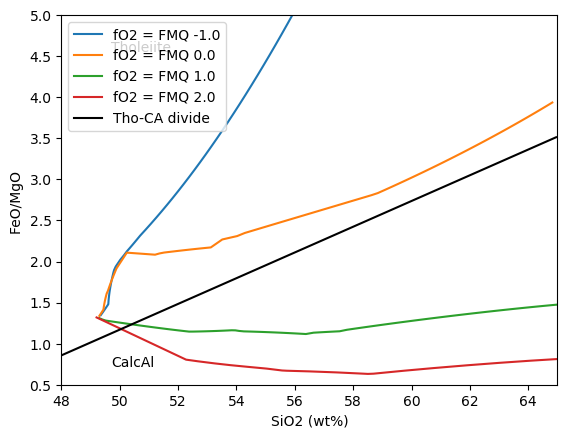

In [17]:
# Lets loop through the different keys and plot FeO vs MgO
x='SiO2_Liq'
y='FeO/MgO'
for key in Isobaric_Xtal_fo2.keys():
    # Lets add a column for FeO/MgO
    Isobaric_Xtal_fo2[key]['All']['FeO/MgO']=Isobaric_Xtal_fo2[key]['All']['FeOt_Liq']/Isobaric_Xtal_fo2[key]['All']['MgO_Liq']
    plt.plot(Isobaric_Xtal_fo2[key]['All'][x],Isobaric_Xtal_fo2[key]['All'][y],
         '-', label=key)
    
# Lets add approximate boundary from web plot digitizer!
plt.plot([45, 64.95495495495496],  [0.3876918668171161, 3.5129224652087476], '-k', label='Tho-CA divide')
plt.xlim([48, 65])
plt.ylim([0.5, 5])
plt.annotate('CalcAl', xy=[0.1, 0.05], xycoords="axes fraction", fontsize=10)
plt.annotate('Tholeiite', xy=[0.1, 0.9], xycoords="axes fraction", fontsize=10)
plt.ylabel('FeO/MgO ')
plt.xlabel('SiO2 (wt%)')
plt.legend()

## Part 3 - What's causing the differences?

Okay, let's now look at what's causing the differences!

**Remember the `phase_plot` function above? Try using it here to plot the predicted phase abundance for the models with different H2O contents. What do you notice about the onset of plagioclase crystallization?**

(<Figure size 500x350 with 1 Axes>,
 ([<Figure size 500x350 with 1 Axes>,
   <Figure size 500x350 with 1 Axes>,
   <Figure size 500x350 with 1 Axes>,
   <Figure size 500x350 with 1 Axes>],
  [<Axes: title={'center': 'H2O = 0.5 wt%'}, xlabel='MgO_Liq', ylabel='Mass fraction'>,
   <Axes: title={'center': 'H2O = 2.0 wt%'}, xlabel='MgO_Liq', ylabel='Mass fraction'>,
   <Axes: title={'center': 'H2O = 4.0 wt%'}, xlabel='MgO_Liq', ylabel='Mass fraction'>,
   <Axes: title={'center': 'H2O = 6.0 wt%'}, xlabel='MgO_Liq', ylabel='Mass fraction'>]))

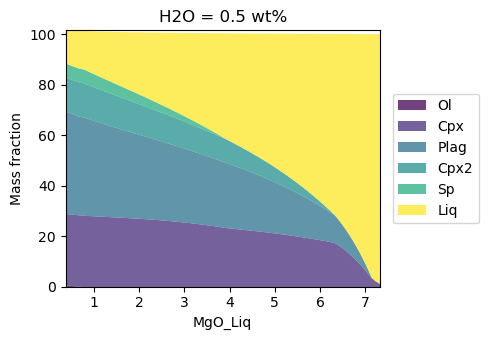

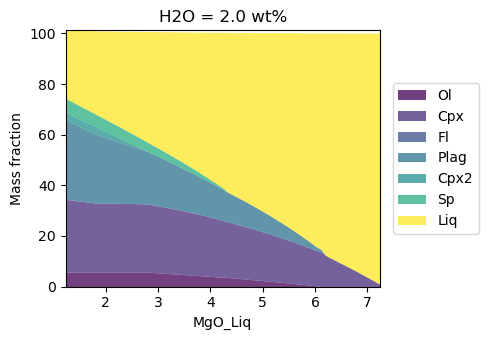

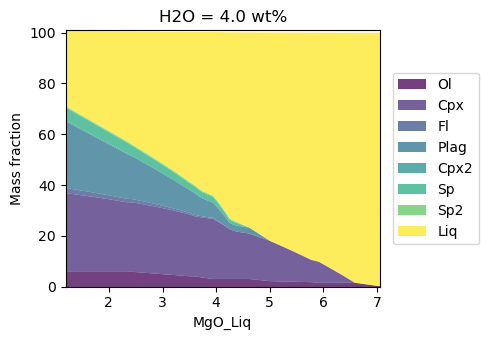

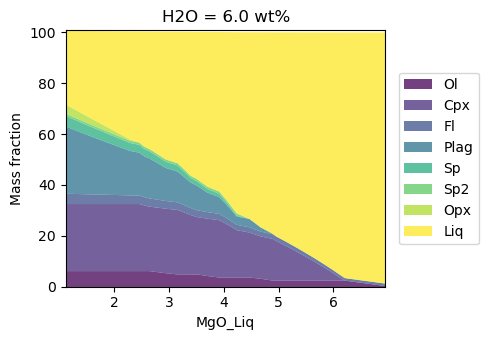

In [18]:
ptt.phase_plot(Results = Isobaric_Xtal_H2O, cmap = 'viridis', x_axis='MgO_Liq')

**Now do a similar thing with the models ran at differen oxygen fugacities. What happens to the onset (and mass) of spinel crystallization (note - spinel includes magnetite and ilmenite)?**

(<Figure size 500x350 with 1 Axes>,
 ([<Figure size 500x350 with 1 Axes>,
   <Figure size 500x350 with 1 Axes>,
   <Figure size 500x350 with 1 Axes>,
   <Figure size 500x350 with 1 Axes>],
  [<Axes: title={'center': 'fO2 = FMQ -1.0'}, xlabel='MgO_Liq', ylabel='Mass fraction'>,
   <Axes: title={'center': 'fO2 = FMQ 0.0'}, xlabel='MgO_Liq', ylabel='Mass fraction'>,
   <Axes: title={'center': 'fO2 = FMQ 1.0'}, xlabel='MgO_Liq', ylabel='Mass fraction'>,
   <Axes: title={'center': 'fO2 = FMQ 2.0'}, xlabel='MgO_Liq', ylabel='Mass fraction'>]))

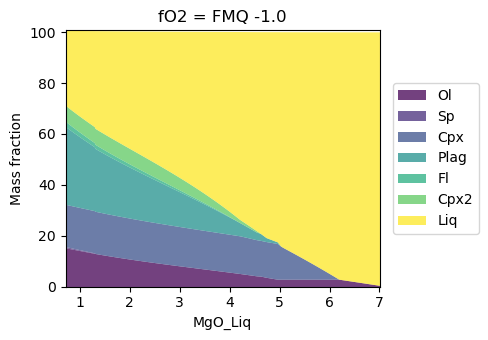

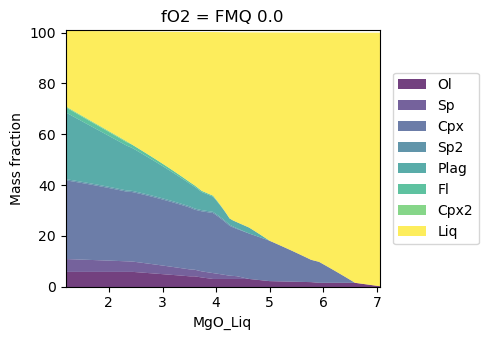

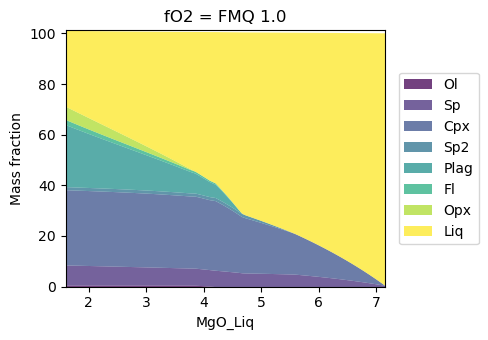

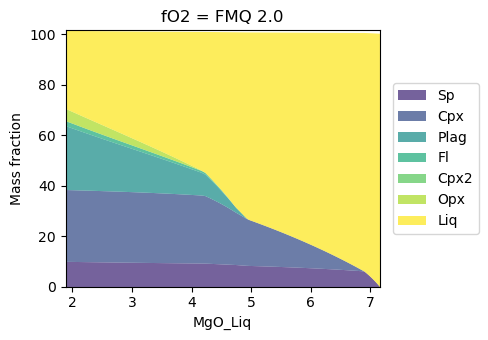

In [19]:
ptt.phase_plot(Results = Isobaric_Xtal_fo2, cmap = 'viridis', x_axis='MgO_Liq')

### Is this the easiest way to visualize phase abundance?

**When we run multiple models we can also plot up the mass of individual phases using the `phase_mass_comparison` function. Try it out below for plagioclase and spinel in the H2O and fO2 models.**

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='MgO_Liq', ylabel='Mass (g) of plagioclase'>)

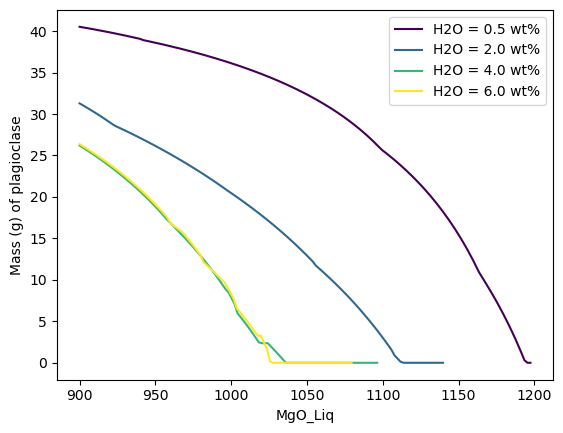

In [20]:
ptt.phase_mass_comparison(Results=Isobaric_Xtal_H2O, x_axis="MgO_Liq", cmap = "viridis", phase = "plagioclase1")

## Part 4 - Are the results the same with different thermodynamic models

To run calculations in MAGEMinCalc you can use exactly the same functions as above, just change the Model key-word argument to 'Green2025' or 'Weller2024'.

In [21]:
Isobaric_Xtal_fo2_MM = ptt.isobaric_crystallisation(Model = "Green2025",
                                           bulk = Aleutian,
                                           find_liquidus = True,
                                           P_bar = 2000,
                                           H2O_init=4,
                                           T_end_C = 900,
                                           dt_C = 2,
                                           fO2_buffer = "FMQ",
                                           fO2_offset = [-1,0,1,2],
                                           Frac_solid = True,
                                           Frac_fluid = True,
                                           label = "fO2",
                                           timeout=90)

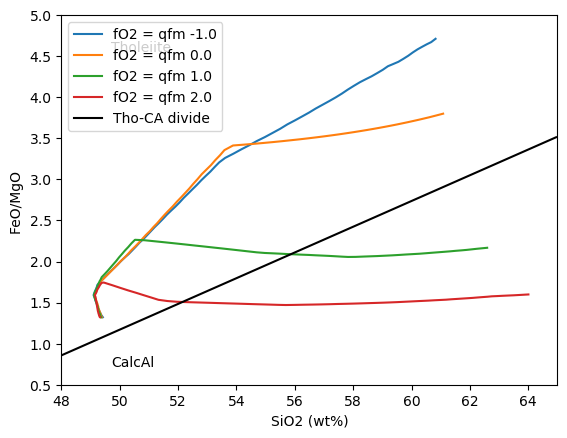

In [22]:
# Lets loop through the different keys and plot FeO vs MgO
x='SiO2_Liq'
y='FeO/MgO'
for key in Isobaric_Xtal_fo2_MM.keys():
    # Lets add a column for FeO/MgO
    Isobaric_Xtal_fo2_MM[key]['All']['FeO/MgO']=Isobaric_Xtal_fo2_MM[key]['All']['FeOt_Liq']/Isobaric_Xtal_fo2_MM[key]['All']['MgO_Liq']
    plt.plot(Isobaric_Xtal_fo2_MM[key]['All'][x],Isobaric_Xtal_fo2_MM[key]['All'][y],
         '-', label=key)
    
# Lets add approximate boundary from web plot digitizer!
plt.plot([45, 64.95495495495496],  [0.3876918668171161, 3.5129224652087476], '-k', label='Tho-CA divide')
plt.xlim([48, 65])
plt.ylim([0.5, 5])
plt.annotate('CalcAl', xy=[0.1, 0.05], xycoords="axes fraction", fontsize=10)
plt.annotate('Tholeiite', xy=[0.1, 0.9], xycoords="axes fraction", fontsize=10)
plt.ylabel('FeO/MgO ')
plt.xlabel('SiO2 (wt%)')
plt.legend()

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='MgO_Liq', ylabel='Mass (g) of spinel'>)

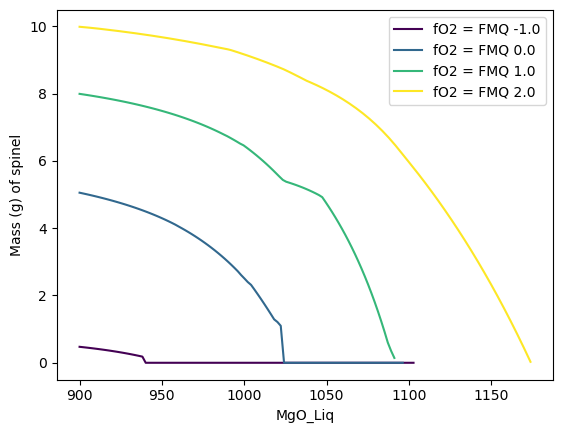

In [23]:
ptt.phase_mass_comparison(Results=Isobaric_Xtal_fo2, x_axis="MgO_Liq", cmap = "viridis", phase = "spinel1")

### Bonus - advise not to run in workshop

**Testing 8 different models gives us some insights, but potentially not enought to really understand a system. In the cells below I show how we can use the high MgO data from Augustine and Shishaldin to generate ~500 hypothetical starting compositions. We can then run these 500 compositions, at randomly chosen fO2, H2O and pressure conditions, and examine which models generate calc-alkaline or tholeiite differentiation trends.**

<Axes: xlabel='MgO_Liq', ylabel='SiO2_Liq'>

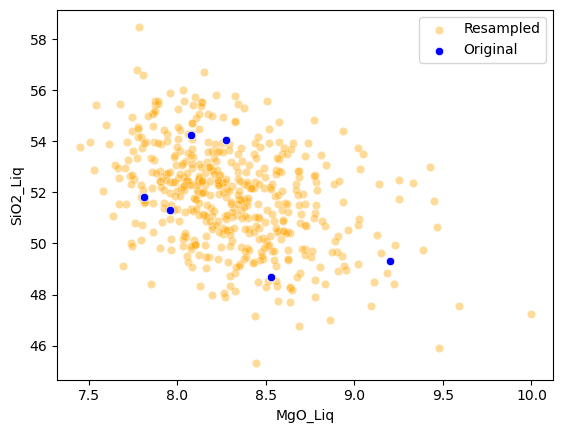

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Calculate Correlation and Covariance
Alue_MgO = Aleu.loc[(Aleu['MgO_Liq'] > 7) & (Aleu['MgO_Liq']<10)].copy()

numeric_df = Alue_MgO.drop(columns=['Volcano'])
means = numeric_df.mean()
cov_matrix = numeric_df.cov()

# 2. Define Constraints
cols_to_check = [c for c in numeric_df.columns]

# 3. Resample with Rejection Sampling (to ensure no negatives)
valid_samples = []
target_count = 500

while len(valid_samples) < target_count:
    # Generate a batch of samples
    samples = np.random.multivariate_normal(means, cov_matrix, size=target_count)
    batch_df = pd.DataFrame(samples, columns=numeric_df.columns)
    
    # Filter: Keep rows where all specified columns are >= 0
    mask = (batch_df[cols_to_check] >= 0).all(axis=1)
    valid_samples.append(batch_df[mask])
    
    # Safety break if sampling is impossible
    if len(valid_samples) > 100: break 

df_resampled = pd.concat(valid_samples).iloc[:target_count].reset_index(drop=True)

# 4. Plot results
sns.scatterplot(data=df_resampled, x='MgO_Liq', y='SiO2_Liq', alpha=0.4, label='Resampled', color='orange')
sns.scatterplot(data=numeric_df, x='MgO_Liq', y='SiO2_Liq', label='Original', color='blue')

In [27]:
H2O_init = np.random.random(len(df_resampled))*7.8 + 0.2
fO2_buffer = np.random.random(len(df_resampled))*4 - 1.0
P_bar = np.random.random(len(df_resampled))*4500 + 500

In [28]:
Isobaric_Xtal_all = ptt.isobaric_crystallisation(Model = "MELTSv1.2.0",
                                           bulk = df_resampled,
                                           find_liquidus = True,
                                           P_bar = P_bar,
                                           H2O_init=H2O_init,
                                           T_end_C = 900,
                                           dt_C = 2,
                                           fO2_buffer = "FMQ",
                                           fO2_offset = fO2_buffer,
                                           Frac_solid = True,
                                           Frac_fluid = True,
                                           timeout=10)

In [29]:
len(Isobaric_Xtal_all.keys())

496

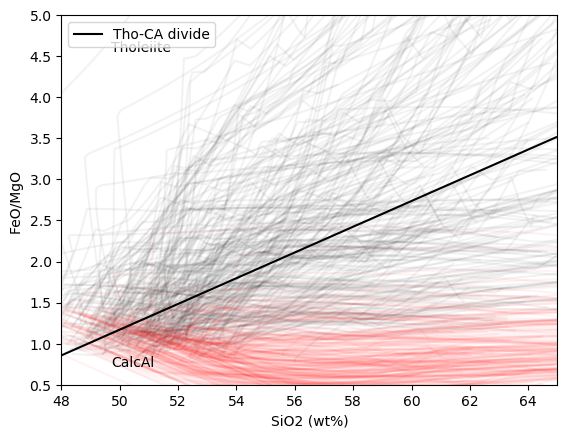

In [30]:
# Lets loop through the different keys and plot FeO vs MgO
x='SiO2_Liq'
y='FeO/MgO'
for key in Isobaric_Xtal_all.keys():
    # Lets add a column for FeO/MgO
    if Isobaric_Xtal_all[key]['Input']['fO2_offset'] < 1:
        Isobaric_Xtal_all[key]['All']['FeO/MgO']=Isobaric_Xtal_all[key]['All']['FeOt_Liq']/Isobaric_Xtal_all[key]['All']['MgO_Liq']
        plt.plot(Isobaric_Xtal_all[key]['All'][x],Isobaric_Xtal_all[key]['All'][y],
            '-k', alpha = 0.05, zorder = 0)
    else:
        Isobaric_Xtal_all[key]['All']['FeO/MgO']=Isobaric_Xtal_all[key]['All']['FeOt_Liq']/Isobaric_Xtal_all[key]['All']['MgO_Liq']
        plt.plot(Isobaric_Xtal_all[key]['All'][x],Isobaric_Xtal_all[key]['All'][y],
            '-r', alpha = 0.05, zorder = 1)
    
# Lets add approximate boundary from web plot digitizer!
plt.plot([45, 64.95495495495496],  [0.3876918668171161, 3.5129224652087476], '-k', label='Tho-CA divide')
plt.xlim([48, 65])
plt.ylim([0.5, 5])
plt.annotate('CalcAl', xy=[0.1, 0.05], xycoords="axes fraction", fontsize=10)
plt.annotate('Tholeiite', xy=[0.1, 0.9], xycoords="axes fraction", fontsize=10)
plt.ylabel('FeO/MgO ')
plt.xlabel('SiO2 (wt%)')
plt.legend()